In [63]:
pip install --upgrade keras keras-applications

Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.8.0


In [65]:
from keras import applications
resnet = applications.resnet.ResNet101(include_top=False, weights=None, input_shape=(200,200,3))
print(type(resnet))

<class 'keras.engine.functional.Functional'>


In [68]:
from keras.engine.functional import decode_predictions

ImportError: cannot import name 'decode_predictions' from 'keras.engine.functional' (/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py)

In [69]:
inceptionV3_model = keras.models.load_model('final')

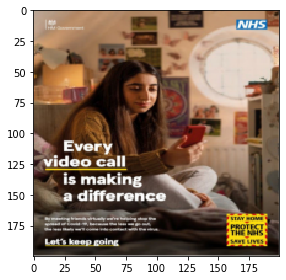

In [70]:
Xi = skimage.io.imread("/Users/mahelwimaladasa/Desktop/Ratings/Training/01 Very Good/Image00001.jpeg")
Xi = skimage.transform.resize(Xi, (200,200)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) #Show image before inception preprocessing

In [71]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds, top=4)[0] 

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 4)

In [72]:
top_pred_classes = preds[0].argsort()[-4:][::-1]
top_pred_classes 

array([0, 3, 2, 1])

In [73]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

31

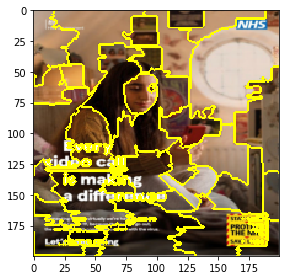

In [74]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [75]:
num_perturb = 20 #Create 20 pertubations, use a large number for a better interpretation
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
print('Shape = ', perturbations.shape)
print('First pertubation = ', perturbations[0]) #Show example of perturbation

Shape =  (20, 31)
First pertubation =  [1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1]


In [76]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

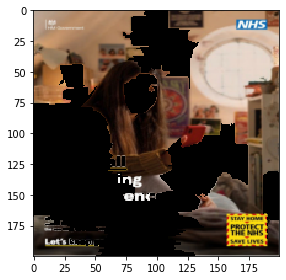

In [77]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels)) 

In [78]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(20, 1, 4)

In [79]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(20,)

In [80]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(20,)

In [81]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.04944812, -0.01973754,  0.05496341, -0.09975828, -0.08376979,
        0.06603891, -0.0291509 ,  0.10730008, -0.09131941, -0.41387409,
       -0.16934278,  0.38863843,  0.18904711,  0.04427541, -0.05232015,
        0.11752332,  0.01870011,  0.18652199,  0.07791741,  0.19762398,
       -0.08706396,  0.00516429,  0.15898723, -0.12398875,  0.041305  ,
        0.13939573, -0.09087381,  0.14221114, -0.09225718,  0.03066021,
       -0.11842512])

In [82]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([17, 12, 19, 11])

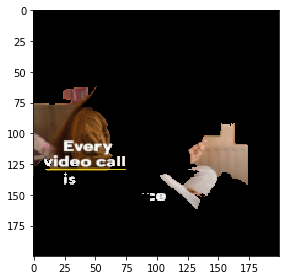

In [83]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )